#  Melt Rate as a function of Depth

Created by Claire Yung

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [2]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'


# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


In [3]:
sPerYr = 365.*24.*60.*60.


In [15]:
#12 model colours for 12 models, generated using https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=12
modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
modellines=['--','-','-','--','dotted','-.',(0,(1,0.5)),'-','-','--','-','-']

/jobfs/148616345.gadi-pbs/ipykernel_2413370/4253838682.py:29: RuntimeWarning: invalid value encountered in divide
  ax.plot(a/c,depth_centres,label = labels[i],color = modelcolours[i],linestyle= modellines[i],
/jobfs/148616345.gadi-pbs/ipykernel_2413370/4253838682.py:29: RuntimeWarning: invalid value encountered in divide
  ax.plot(a/c,depth_centres,label = labels[i],color = modelcolours[i],linestyle= modellines[i],
/jobfs/148616345.gadi-pbs/ipykernel_2413370/4253838682.py:29: RuntimeWarning: invalid value encountered in divide
  ax.plot(a/c,depth_centres,label = labels[i],color = modelcolours[i],linestyle= modellines[i],
/jobfs/148616345.gadi-pbs/ipykernel_2413370/4253838682.py:29: RuntimeWarning: invalid value encountered in divide
  ax.plot(a/c,depth_centres,label = labels[i],color = modelcolours[i],linestyle= modellines[i],
/jobfs/148616345.gadi-pbs/ipykernel_2413370/4253838682.py:29: RuntimeWarning: invalid value encountered in divide
  ax.plot(a/c,depth_centres,label = labels[i],

Text(0.5, 1.02, 'Melt Rate Distribution with Depth, year 20')

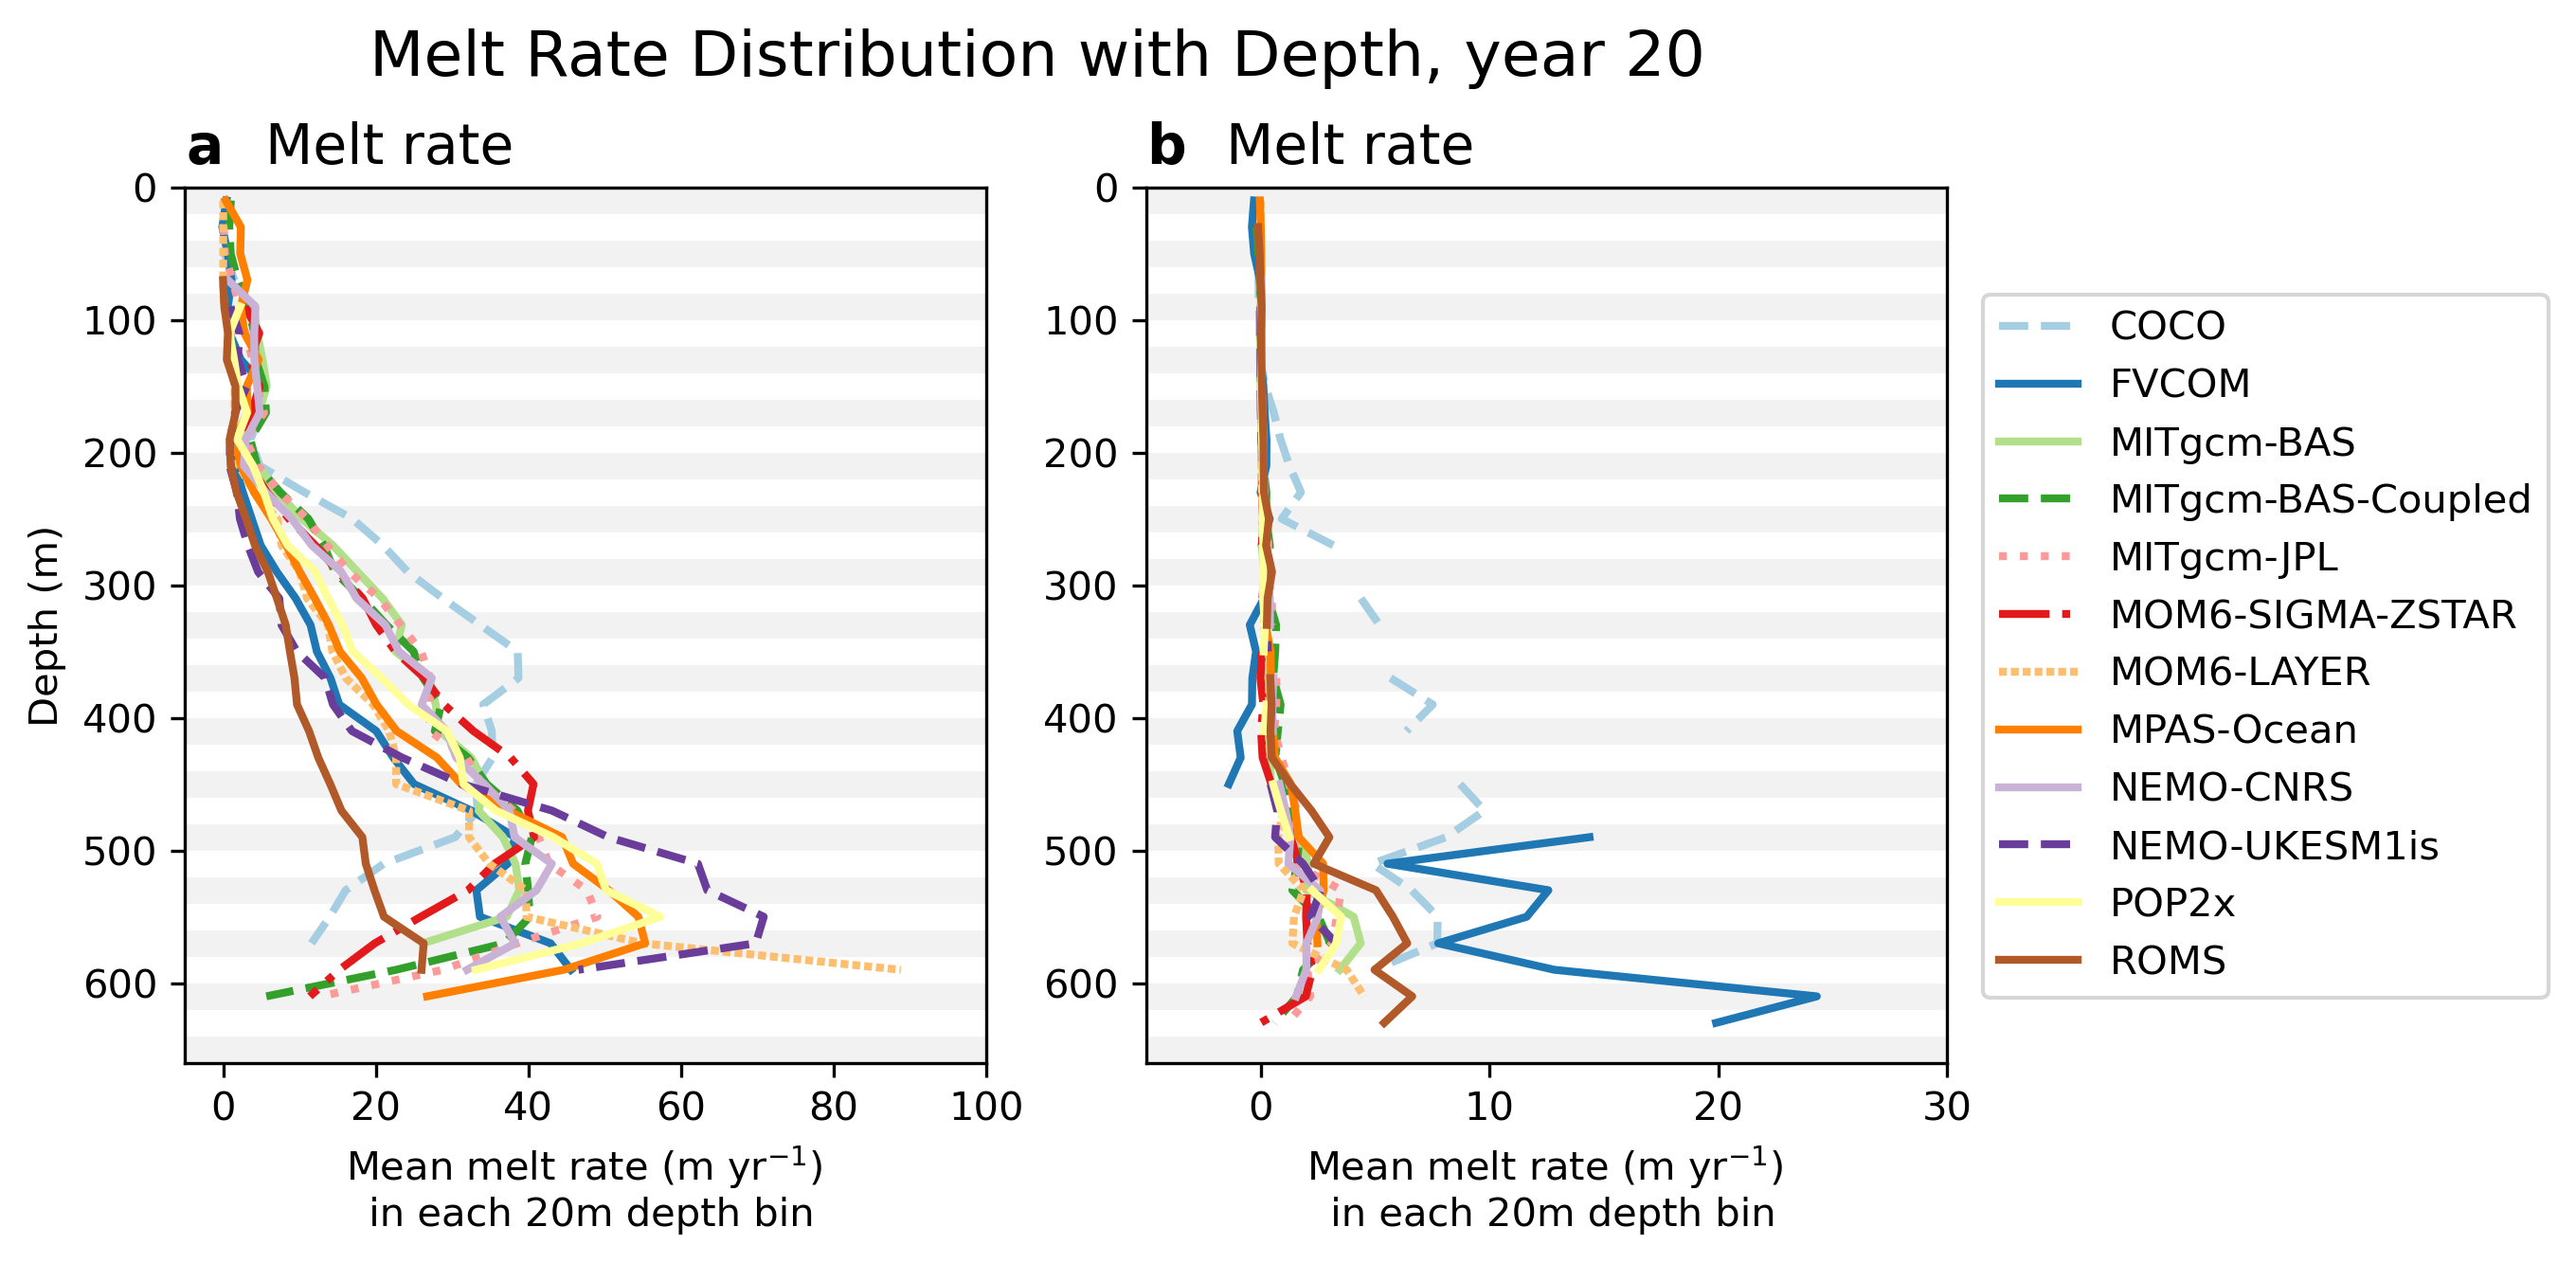

In [16]:
fig,axes = plt.subplots(ncols = 2,figsize=(8, 4),facecolor='w',dpi = 300)
depth_bins = np.linspace(0,720,37)
depth_centres = ((np.linspace(0,720,37) + np.roll(np.linspace(0,720,37),-1))/2)[:-1]
expt = Ocean1_COM
labels = get_labels(expt)
length = len(expt)
# Plot mean melt
ax = axes[0]
for i in np.arange(length):
    #print(expt[i])
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time'])
    nTime = ds.sizes['nTime']
    mr = ds.meltRate.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # mr < 1e36 is to get rid of fill values.
    mr = mr.where(mr < 1e36) * sPerYr
    try:
        draft = ds.iceDraft.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    except ValueError:
        draft = ds.iceDraft#.isel(nTime = time)
    depth = np.abs(draft)
    depth_ravel = np.ravel(depth)
    mr_ravel = np.ravel(mr)
    depth_ravel = depth_ravel[mr_ravel<1e9]
    mr_ravel = mr_ravel[mr_ravel<1e9]
    a,b = np.histogram(depth_ravel,depth_bins,weights = mr_ravel)
    c,d = np.histogram(depth_ravel,depth_bins)
    ax.plot(a/c,depth_centres,label = labels[i],color = modelcolours[i],linestyle= modellines[i],
              linewidth = 2)
xmax = 100
xmin = -5
for i in np.arange(18):
    ax.fill_between(np.linspace(xmin,xmax), depth_bins[2*i],depth_bins[2*i+1],color = 'grey',alpha = 0.1,linewidth = 0)
ax.set_ylim(660,0)
ax.set_xlim(xmin,xmax)
ax.set_xlabel('Mean melt rate (m yr$^{-1}$) \n in each 20m depth bin')
ax.set_ylabel('Depth (m)')
ax.set_title('Melt rate',fontsize = 14,ha='left', x=0.1)
ax.text(0.025,1.045,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax.transAxes, fontsize = 14)


expt = Ocean2_COM
labels = get_labels(expt)
length = len(expt)

# Plot mean melt
ax = axes[1]
for i in np.arange(length):
    #print(expt[i])
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time'])
    nTime = ds.sizes['nTime']
    mr = ds.meltRate.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # mr < 1e36 is to get rid of fill values.
    mr = mr.where(mr < 1e36) * sPerYr
    try:
        draft = ds.iceDraft.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    except ValueError:
        draft = ds.iceDraft#.isel(nTime = time)
    depth = np.abs(draft)
    depth_ravel = np.ravel(depth)
    mr_ravel = np.ravel(mr)
    depth_ravel = depth_ravel[mr_ravel<1e9]
    mr_ravel = mr_ravel[mr_ravel<1e9]
    a,b = np.histogram(depth_ravel,depth_bins,weights = mr_ravel)
    c,d = np.histogram(depth_ravel,depth_bins)
    ax.plot(a/c,depth_centres,label = labels[i],color = modelcolours[i],linestyle= modellines[i],
              linewidth = 2)
xmax = 30
xmin = -5
for i in np.arange(18):
    ax.fill_between(np.linspace(xmin,xmax), depth_bins[2*i],depth_bins[2*i+1],color = 'grey',alpha = 0.1,linewidth = 0)
ax.set_ylim(660,0)
ax.set_xlim(xmin,xmax)
ax.set_xlabel('Mean melt rate (m yr$^{-1}$) \n in each 20m depth bin')
ax.set_title('Melt rate',fontsize = 14,ha='left', x=0.1)
ax.text(0.025,1.045,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax.transAxes, fontsize = 14)

ax.legend(loc = 'upper left', bbox_to_anchor = (1.02,0.9))

plt.suptitle('Melt Rate Distribution with Depth, year 20', fontsize = 16, y = 1.02)

### 